# **Football Player Segmentation**

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## I. Dataset and Dataloaders

### I.1. Dataset

In [2]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
# from torchvision import transforms
from pycocotools import mask as coco_mask

class FootballSegmentDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None, frame_step=1):
        self.root_dir = root_dir
        self.transforms = transforms
        self.frame_step = frame_step

        with open(annotation_file, 'r') as f:
            self.coco = json.load(f)

        self.image_id_to_info = {img['id']: img for img in self.coco['images']}
        self.id_to_annotations = {}

        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.id_to_annotations:
                self.id_to_annotations[img_id] = []
            self.id_to_annotations[img_id].append(ann)

        # Filter image IDs with step
        full_ids = list(self.id_to_annotations.keys())
        self.image_ids = full_ids[::self.frame_step]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.image_id_to_info[img_id]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        height, width = img_info['height'], img_info['width']
        anns = self.id_to_annotations[img_id]
        masks = []
        for ann in anns:
            segmentation = ann['segmentation']
            rles = coco_mask.frPyObjects(segmentation, height, width)
            rle = coco_mask.merge(rles)
            m = coco_mask.decode(rle)
            masks.append(m)

        if masks:
            mask = np.any(np.stack(masks, axis=0), axis=0).astype(np.uint8)
        else:
            mask = np.zeros((height, width), dtype=np.uint8)

        mask = Image.fromarray(mask)

        if self.transforms:
            img, mask = self.transforms(img, mask)
        else:
            img = T.ToTensor()(img)
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask


### I.2. Transform

In [3]:
import random
from torchvision.transforms import functional as F

# Augmentations for TRAINING only
class JointTrainTransform:
    def __init__(self, resize=(256, 256), hflip_prob=0.5, vflip_prob=0.5):
        self.resize = resize
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.color_jitter = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    def __call__(self, img, mask):
        img = F.resize(img, self.resize)
        mask = F.resize(mask, self.resize, interpolation=Image.NEAREST)

        if random.random() < self.hflip_prob:
            img = F.hflip(img)
            mask = F.hflip(mask)

        if random.random() < self.vflip_prob:
            img = F.vflip(img)
            mask = F.vflip(mask)

        img = self.color_jitter(img)
        img = F.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()
        img = self.normalize(img)
        return img, mask

# Minimal transform for VAL & TEST
class JointEvalTransform:
    def __init__(self, resize=(256, 256)):
        self.resize = resize
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    def __call__(self, img, mask):
        img = F.resize(img, self.resize)
        mask = F.resize(mask, self.resize, interpolation=Image.NEAREST)

        img = F.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()
        img = self.normalize(img)
        return img, mask

### I.3. Train loader and test loader

In [4]:
import torch.utils.data as data
from torchvision import utils
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset

resize=(256, 256)
frame_step=5

# Dataset
train_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=JointTrainTransform(resize=resize),
    frame_step=frame_step
)

val_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=JointEvalTransform(resize=resize),
    frame_step=frame_step
)

test_dataset = FootballSegmentDataset(
    root_dir='dataset1/images',
    annotation_file='dataset1/annotations/instances_default.json',
    transforms=JointEvalTransform(resize=resize),
    frame_step=frame_step
)

# Splitting
#-- Dataset splitting: Train - Val - Test: 70-15-15
#-- Train: 70%
#-- Val: 15% for comparison between models
#-- Test: 15% for final estimation of the model performance

total_size = len(train_dataset)
indices = list(range(total_size))
np.random.seed(42)
np.random.shuffle(indices)

train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

trainset = Subset(train_dataset, train_idx)
valset = Subset(val_dataset, val_idx)
testset = Subset(test_dataset, test_idx)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

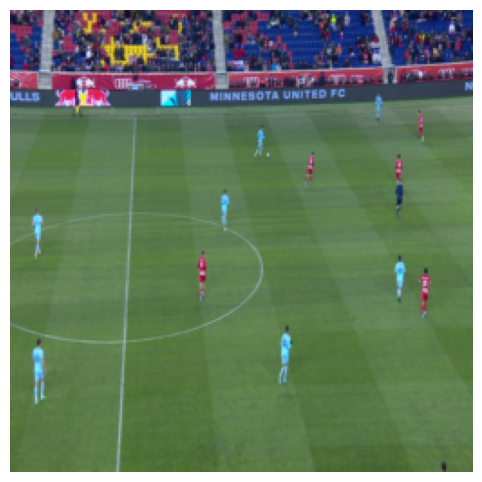

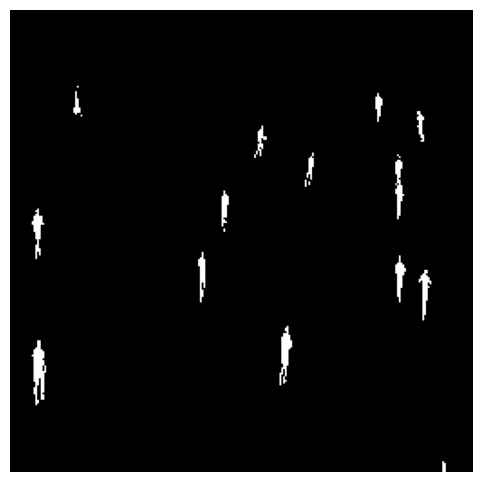

In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms import functional as F

def show_images(imgs, title="Images"):
    # imgs: batch tensor of shape (B, C, H, W)
    img_grid = make_grid(imgs, nrow=4, normalize=True)
    img_pil = F.to_pil_image(img_grid)
    plt.figure(figsize=(12, 6))
    plt.imshow(img_pil)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_masks(masks, title="Masks"):
    # masks: batch tensor of shape (B, 1, H, W) or (B, H, W)
    # Convert to grid and use grayscale colormap
    if masks.dim() == 4:
        masks = masks.squeeze(1)  # (B, H, W)
    mask_grid = make_grid(masks.unsqueeze(1).float(), nrow=4, normalize=True)
    mask_pil = F.to_pil_image(mask_grid)
    plt.figure(figsize=(12, 6))
    plt.imshow(mask_pil, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load 1 batch
images, masks = next(iter(valloader))

# Visualize
show_images(images, title="")
show_masks(masks, title="")

## II. Model predicted mask

In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import functional as F
import numpy as np


def show_only_predicted_mask(model, dataloader, threshold=0.5, device='cuda'):
    model.eval()
    model.to(device)

    images, _ = next(iter(dataloader))
    images = images.to(device)

    with torch.no_grad():
        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()

    pred = preds[0].cpu().squeeze(0)

    plt.imshow(pred, cmap='gray')
    plt.axis('off')
    plt.show()




def show_only_transformed_image(dataloader, threshold=0.5, device='cuda'):

    images, _ = next(iter(dataloader))
    images = images.to(device)

    image = images[0].cpu()

    plt.imshow(F.to_pil_image(image))
    plt.axis('off')
    plt.show()



import matplotlib.pyplot as plt

def show_prediction_error_colormap(model, dataloader, threshold=0.5, device='cuda'):
    model.eval()
    model.to(device)

    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.to(device).float().unsqueeze(1)  # Ensure shape is (B, 1, H, W)

    with torch.no_grad():
        logits = model(images)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()

    # Select the first image, predicted mask, and ground truth
    pred = preds[0].cpu().squeeze().numpy()
    true = masks[0].cpu().squeeze().numpy()

    # Initialize RGB image
    h, w = pred.shape
    result = np.zeros((h, w, 3), dtype=np.uint8)

    # True Positive (1 & 1) → white
    result[(true == 1) & (pred == 1)] = [255, 255, 255]

    # False Negative (true=1, pred=0) → green
    result[(true == 1) & (pred == 0)] = [0, 255, 0]

    # False Positive (true=0, pred=1) → red
    result[(true == 0) & (pred == 1)] = [255, 0, 0]

    # True Negative (0 & 0) → black (already zero)

    # Show the error map
    plt.imshow(result)
    plt.axis('off')
    # plt.title("Prediction Error Visualization")
    plt.show()
    

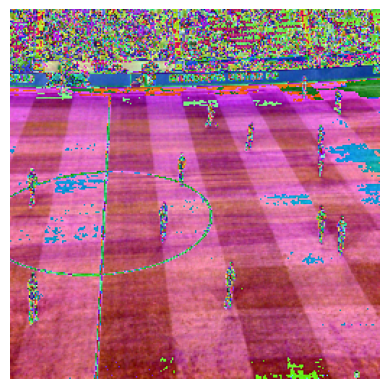

In [7]:
show_only_transformed_image(valloader, threshold=0.5, device=device)

## Model and plot

### TinyUNet

In [8]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        #print(f"Block: x.shape = {x.shape}, out_channels = {self.block[0].out_channels}")
        return self.block(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = Block(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        #print(f"Down: x.shape = {x.shape}")
        x = self.block(x)
        x_down = self.down(x)
        return x, x_down
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        self.block = Block(in_channels + in_channels, out_channels)

    def forward(self, x, skip):
        #print(f"Up: x.shape = {x.shape}, skip.shape = {skip.shape}")
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)  
        x = self.block(x)
        return x

class TinyUnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.middle = Block(256, 256)
        self.up3 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up1 = Up(64, 32)
        self.conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # x is (B, in_channels, H, W)
        x1, x = self.down1(x)  # x1 is (B, 64, H, W), x is (B, 64, H/2, W/2)
        x2, x = self.down2(x)  # x2 is (B, 128, H/2, W/2), x is (B, 128, H/4, W/4)
        x3, x = self.down3(x)  # x3 is (B, 256, H/4, W/4), x is (B, 256, H/8, W/8)
        x = self.middle(x)     # x is (B, 256, H/8, W/8)
        x = self.up3(x, x3)    # x is (B, 128, H/4, W/4)
        x = self.up2(x, x2)    # x is (B, 64, H/2, W/2)
        x = self.up1(x, x1)    # x is (B, 32, H, W)
        x = self.conv(x)       # x is (B, out_channels, H, W)
        return x

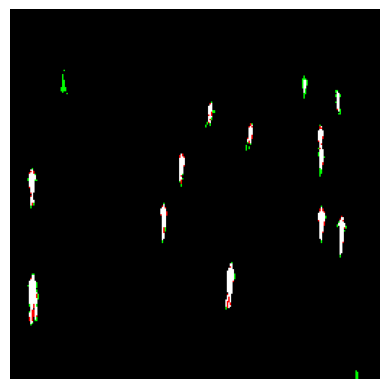

In [9]:
model = TinyUnet(in_channels=3, out_channels=1)

model.load_state_dict(torch.load("outputs/TinyUNet/TinyUNet_lr0.0001_bs4_ep40_BCEWithLogitsLoss_model.pt", map_location=device))

model = model.to(device)

show_prediction_error_colormap(model, valloader, threshold=0.5, device=device)

### UNet

In [10]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = Block(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.block(x)
        x_down = self.down(x)
        return x, x_down

class Up(nn.Module):
    def __init__(self, up_in_channels, skip_in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(up_in_channels, skip_in_channels, kernel_size=2, stride=2)
        self.block = Block(skip_in_channels + skip_in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        diffY = skip.size()[2] - x.size()[2]
        diffX = skip.size()[3] - x.size()[3]
        x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                                  diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)

        self.middle = Block(512, 1024)

        self.up4 = Up(1024, 512, 512)
        self.up3 = Up(512, 256, 256)
        self.up2 = Up(256, 128, 128)
        self.up1 = Up(128, 64, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1, x = self.down1(x)  # x1: 64
        x2, x = self.down2(x)  # x2: 128
        x3, x = self.down3(x)  # x3: 256
        x4, x = self.down4(x)  # x4: 512

        x = self.middle(x)     # 1024

        x = self.up4(x, x4)    # (1024 → 512) + 512 = 1024 → 512
        x = self.up3(x, x3)    # (512 → 256) + 256 = 512 → 256
        x = self.up2(x, x2)    # (256 → 128) + 128 = 256 → 128
        x = self.up1(x, x1)    # (128 → 64) + 64 = 128 → 64

        return self.final_conv(x)


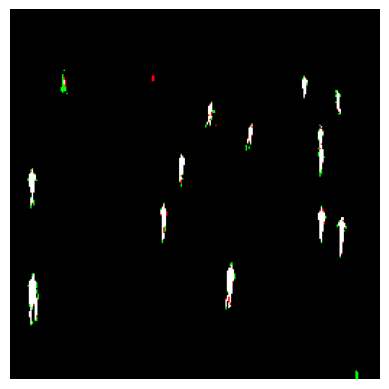

In [11]:
model = UNet(in_channels=3, out_channels=1)

model.load_state_dict(torch.load("outputs/UNet/UNet_lr0.0001_bs4_ep40_BCEWithLogitsLoss_model.pt", map_location=device))

model = model.to(device)

show_prediction_error_colormap(model, valloader, threshold=0.5, device=device)

### UNet++

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F_nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNetPlusPlus(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        n1 = 64
        filters = [n1, n1*2, n1*4, n1*8, n1*16]

        # Encoder
        self.conv0_0 = ConvBlock(in_ch, filters[0])
        self.conv1_0 = ConvBlock(filters[0], filters[1])
        self.conv2_0 = ConvBlock(filters[1], filters[2])
        self.conv3_0 = ConvBlock(filters[2], filters[3])
        self.conv4_0 = ConvBlock(filters[3], filters[4])

        # Decoder (nested)
        self.conv0_1 = ConvBlock(filters[0]+filters[1], filters[0])
        self.conv1_1 = ConvBlock(filters[1]+filters[2], filters[1])
        self.conv2_1 = ConvBlock(filters[2]+filters[3], filters[2])
        self.conv3_1 = ConvBlock(filters[3]+filters[4], filters[3])

        self.conv0_2 = ConvBlock(filters[0]*2 + filters[1], filters[0])
        self.conv1_2 = ConvBlock(filters[1]*2 + filters[2], filters[1])
        self.conv2_2 = ConvBlock(filters[2]*2 + filters[3], filters[2])

        self.conv0_3 = ConvBlock(filters[0]*3 + filters[1], filters[0])
        self.conv1_3 = ConvBlock(filters[1]*3 + filters[2], filters[1])

        self.conv0_4 = ConvBlock(filters[0]*4 + filters[1], filters[0])

        # Final convolution layers
        if self.deep_supervision:
            self.final = nn.ModuleList([nn.Conv2d(filters[0], out_ch, kernel_size=1) for _ in range(4)])
        else:
            self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.up = lambda x, scale_factor=2: F_nn.interpolate(x, scale_factor=scale_factor, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Decoder
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            outputs = [self.final[i](x) for i, x in enumerate([x0_1, x0_2, x0_3, x0_4])]
            return outputs
        else:
            return self.final(x0_4)

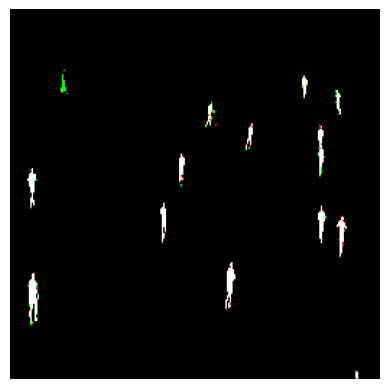

In [13]:
model = UNetPlusPlus(in_ch=3, out_ch=1, deep_supervision=False)

model.load_state_dict(torch.load("outputs/UNetpp/UNetpp_lr0.0001_bs4_ep40_BCEWithLogitsLoss_model.pt", map_location=device))

model = model.to(device)

show_prediction_error_colormap(model, valloader, threshold=0.5, device=device)


### ResUNet

In [14]:
# ResUNet architecture

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.same_channels = (in_channels == out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.res_conv(identity)
        out += identity
        return self.relu(out)

class ResUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ResUNet, self).__init__()
        self.enc1 = ResidualBlock(in_channels, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.enc4 = ResidualBlock(256, 512)
        self.center = ResidualBlock(512, 1024)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ResidualBlock(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        center = self.center(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(center), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)

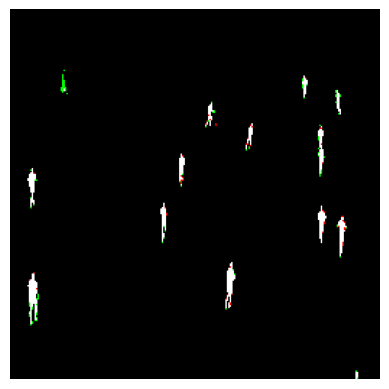

In [15]:
model = ResUNet(in_channels=3, out_channels=1)

model.load_state_dict(torch.load("outputs/ResUNet/ResUNet_lr0.0001_bs4_ep40_BCEWithLogitsLoss_model.pt", map_location=device))

model = model.to(device)

show_prediction_error_colormap(model, valloader, threshold=0.5, device=device)

### ResUNet Deeper (Custom architecture)

In [16]:
import numpy as np
import random # Used for transforms (to allow transform on both images and mask)
import matplotlib.pyplot as plt
import gc
# ResUNet architecture

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.same_channels = (in_channels == out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.res_conv(identity)
        out += identity
        return self.relu(out)

class ResUNet_deeper(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(ResUNet_deeper, self).__init__()
        self.enc1 = ResidualBlock(in_channels, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.enc4 = ResidualBlock(256, 512)
        self.enc5 = ResidualBlock(512, 1024)

        self.center = ResidualBlock(1024, 2048)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.up5 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.dec5 = ResidualBlock(2048, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ResidualBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        center = self.center(self.pool(e5))

        d5 = self.dec5(torch.cat([self.up5(center), e5], dim=1))
        d4 = self.dec4(torch.cat([self.up4(d5), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


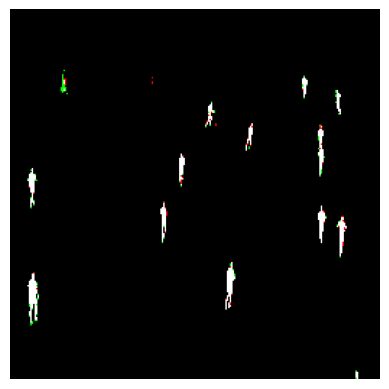

In [17]:
model = ResUNet_deeper(in_channels=3, out_channels=1)

model.load_state_dict(torch.load("outputs/ResUNet_deeper/ResUNet_deeper_lr0.0001_bs4_ep40_BCEWithLogitsLoss_model.pt", map_location=device))

model = model.to(device)

show_prediction_error_colormap(model, valloader, threshold=0.5, device=device)

### ResUNet++ (custom architecture)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F_nn

class ConvBlock(nn.Module): # do not modify shape asides number of channels
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.same_channels = (in_channels == out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        identity = self.res_conv(identity)
        out += identity
        return self.relu(out)

class ResUNetPlusPlus(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        n1 = 64
        filters = [n1, n1*2, n1*4, n1*8, n1*16]

        # Encoder
        self.conv0_0 = ConvBlock(in_ch, filters[0]) 
        self.conv1_0 = ConvBlock(filters[0], filters[1])
        self.conv2_0 = ConvBlock(filters[1], filters[2])
        self.conv3_0 = ConvBlock(filters[2], filters[3])
        self.conv4_0 = ConvBlock(filters[3], filters[4])

        # Decoder (nested)
        self.conv0_1 = ConvBlock(filters[0]+filters[1], filters[0]) # 64+128 -> 64
        self.conv1_1 = ConvBlock(filters[1]+filters[2], filters[1]) # 128+256 -> 128
        self.conv2_1 = ConvBlock(filters[2]+filters[3], filters[2]) # 256+512 -> 256
        self.conv3_1 = ConvBlock(filters[3]+filters[4], filters[3]) # 512+1024 -> 512

        self.conv0_2 = ConvBlock(filters[0]*2 + filters[1], filters[0]) # 64*2+128=256 -> 64
        self.conv1_2 = ConvBlock(filters[1]*2 + filters[2], filters[1]) # 512 -> 128
        self.conv2_2 = ConvBlock(filters[2]*2 + filters[3], filters[2]) # 1024 -> 256

        self.conv0_3 = ConvBlock(filters[0]*3 + filters[1], filters[0]) # 64*3+128 ->64
        self.conv1_3 = ConvBlock(filters[1]*3 + filters[2], filters[1]) # 128*3+256 -> 128

        self.conv0_4 = ConvBlock(filters[0]*4 + filters[1], filters[0]) # 64*4+128 -> 64

        # Final convolution layers
        if self.deep_supervision:
            self.final = nn.ModuleList([nn.Conv2d(filters[0], out_ch, kernel_size=1) for _ in range(4)])
        else:
            self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.up = lambda x, scale_factor=2: F_nn.interpolate(x, scale_factor=scale_factor, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x) # c = 64, h = 256
        x1_0 = self.conv1_0(self.pool(x0_0)) # c=128, h=128
        x2_0 = self.conv2_0(self.pool(x1_0)) # c=256, h=64
        x3_0 = self.conv3_0(self.pool(x2_0)) # c=512, h=32
        x4_0 = self.conv4_0(self.pool(x3_0)) # c=1024, h=16

        # Decoder
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        # x0_1 c=64 h=
        # x0_0 c=64, h=256, upx1_0 c=128, h=128 -> concat c=64+128, h=128
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            outputs = [self.final[i](x) for i, x in enumerate([x0_1, x0_2, x0_3, x0_4])]
            return outputs
        else:
            return self.final(x0_4)

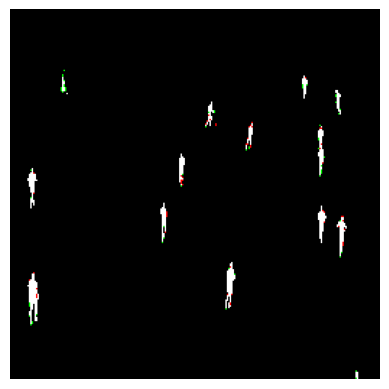

In [19]:
model = ResUNetPlusPlus(in_ch=3, out_ch=1, deep_supervision=False)

model.load_state_dict(torch.load("outputs/ResUNetpp/ResUNetpp_lr0.0001_bs4_ep40_BCEWithLogitsLoss_model.pt", map_location=device))

model = model.to(device)

show_prediction_error_colormap(model, valloader, threshold=0.5, device=device)